In [1]:
import pymongo
from pymongo import MongoClient
from google.cloud import bigquery
from bson import ObjectId
from google.cloud import bigquery_storage_v1
from functools import partialmethod

import datetime as dt
import pandas as pd
import numpy as np
import requests
import json

from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
login = 'user1'
password = 'cPvclw4i57sAFKFk'
db_name = 'hc-prod'

client = MongoClient('mongodb+srv://{}:{}@hc-prod-db.qzq5d.mongodb.net/@hc-prod-db.qzq5d.mongodb.net/{}?retryWrites=true&w=majority'.format(login, password, db_name))
db = client.hc_prod

In [6]:
# Забираем весь фид со ссылками на векторные картинки
# 'https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419' #"DAILY PRODUCTION"
# 'https://cdnmains3.color.auragames.co/feeds/5ef4559473613e00112db462' #"BONUS PRODUCTION"

urls = ['https://cdnmains3.color.auragames.co/feeds/5e4e90dee8a3eb6eaaa117f7',
       'https://cdnmains3.color.auragames.co/feeds/5ef1a73a73613e00112db419'] #"BASE production"
all_feed = pd.DataFrame()

for i in urls:
    url = requests.get(i)
    all_feed_ = url.json()
    all_feed_ = pd.DataFrame(all_feed_['items']) 
    all_feed_ = all_feed_[['id', 'svg', 'type', 'tags', 'createTimestamp']]
    all_feed = pd.concat([all_feed, all_feed_], ignore_index=True, sort=False)    
    
# Извлекаем новые картинки. Они будут вверху списка
new_pectures_time = pd.to_datetime(dt.datetime.utcnow() - dt.timedelta(hours=72))

all_feed['createTimestamp'] = pd.to_datetime(all_feed['createTimestamp']).dt.tz_localize(None)
all_feed['new'] = np.where(all_feed['createTimestamp'] >= new_pectures_time, True, False)
    

In [59]:
all_feed

id                                       svg  \
0     6033c5ee778b890011d97c97                               n7YHb7K.svg   
1     60339481778b890011d97c89                               wXi1Xs8.svg   
2     6033bbc4778b890011d97c93                               NOVbDeR.svg   
3     602fbd52778b890011d97c6f                               HnTjsjx.svg   
4     6033bfc6778b890011d97c94                               _vkDQsS.svg   
...                        ...                                       ...   
2554  5e4fb6c104aea3784208a44e  9969f974-204e-44b1-9475-4d4be8a795f3.svg   
2555  5e4fb65004aea3784208a44d  b60693db-8496-4cbd-b57e-64a625853311.svg   
2556  5e4fb61204aea3784208a44c  bf0575ad-3a22-48f2-ae4b-1f992ab7a51a.svg   
2557  5e4fb40604aea3784208a44b  d375b97f-df61-4176-8b51-bdbe9ccdb6b5.svg   
2558  5e4fb3e104aea3784208a44a  6077d775-ea9f-430c-a170-aa8ad9d92561.svg   

           type               tags         createTimestamp    new  
0     published  [people, fashion] 2021-02-23 00:00:00.000   True  
1     published      [art, people] 2021-02-23 00:00:00.000   True  
2     published             [food] 2021-02-23 00:00:00.000   True  
3     published          [flowers] 2021-02-22 00:00:00.000   True  
4     published   [nature, people] 2021-02-23 00:00:00.000   True  
...         ...                ...                     ...    ...  
2554  published           [nature] 2020-02-21 10:53:53.482  False  
2555  published              [sea] 2020-02-21 10:52:00.404  False  
2556  published              [sea] 2020-02-21 10:50:58.589  False  
2557  published     [travel, food] 2020-02-21 10:42:14.461  False  
2558  published           [people] 2020-02-21 10:41:37.278  False  

[2559 rows x 6 columns]

In [4]:
client = bigquery.Client.from_service_account_json('./lwapps-coloring.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./lwapps-coloring.json')
project_id = 'lwapps-coloring'

sql = '''
with all_data as (
    SELECT distinct event_date, event_timestamp, user_id, 
        if(event_name = 'core_picture_finish', 'picture_finish',
            if(event_name = 'core_picture_start', "picture_start",                    
                if(event_name in ('prelaunch_view', 'prelaunch_new'), 'prelaunch_view', 
                event_name))) as event_name, 
        param.value.string_value as picture_id
    FROM `lwapps-coloring.analytics_218793363.events_*` e,
        UNNEST(event_params) param
    where _TABLE_SUFFIX BETWEEN '20200613' AND '20210309'
    AND e.event_name in ( 
    "picture_finish", "core_picture_finish", 
    'prelaunch_view', 'prelaunch_new',   
    'restart_content', 
    "picture_start", "core_picture_start", 
    'bm_added')
    AND param.key = "picture_id"
    AND NOT (platform = 'IOS' and app_info.version in ('0.1', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', 
    '1.6', '1.7', '1.8', '1.9', '1.10', '1.11'))
    and geo.country != 'Belarus')

select picture_id, event_name, count(distinct user_id) as users_number 
from all_data
group by picture_id, event_name
'''
events_dt = client.query(sql, project=project_id).to_dataframe()


In [7]:
tb = events_dt.copy()
tb = tb.pivot_table(index=['picture_id'], columns='event_name', values='users_number').reset_index()

# Оставляем картинки из base feed
tb = tb[tb.picture_id.isin(all_feed.id.tolist())] 
tb

event_name                picture_id  bm_added  picture_finish  picture_start  \
0           5e4fb33904aea3784208a448     155.0          4104.0         4382.0   
1           5e4fb36904aea3784208a449     206.0          3535.0         3835.0   
2           5e4fb3e104aea3784208a44a     205.0          1417.0         1527.0   
3           5e4fb40604aea3784208a44b     286.0          4169.0         4618.0   
4           5e4fb61204aea3784208a44c     225.0          1723.0         1859.0   
...                              ...       ...             ...            ...   
5220        6041f51bb06e1200115c09b6     363.0         10219.0        12739.0   
5222        60422b6eb06e1200115c09b8     118.0          4252.0         5585.0   
5223        60423895b06e1200115c09b9     152.0          4176.0         5416.0   
5224        604523cd07b32100185ad503     136.0          3339.0         4380.0   
5225        6045288e07b32100185ad504     197.0          3599.0         4996.0   

event_name  prelaunch_view  restart_content  
0                   5426.0              4.0  
1                   4411.0              8.0  
2                   1948.0              2.0  
3                   5981.0             10.0  
4                   2535.0              2.0  
...                    ...              ...  
5220               14593.0             22.0  
5222                7596.0              6.0  
5223                7289.0              3.0  
5224                5948.0              4.0  
5225                6194.0              4.0  

[2911 rows x 6 columns]

In [8]:
tb[['bm_added', "picture_finish", "picture_start", "prelaunch_view", 
    "restart_content"]] = tb[['bm_added', "picture_finish", "picture_start", "prelaunch_view", "restart_content"]].fillna(value=0)


tb['start_coef'] = tb['picture_start']/tb['prelaunch_view']
tb['finish_coef'] = tb['picture_finish']/tb['picture_start']
tb['restart_coef'] = tb['restart_content']/tb['picture_finish']

tb.replace([np.inf, -np.inf], 0, inplace = True)

In [9]:
tb = tb.merge(all_feed[['id', 'createTimestamp', 'new']], how='left', left_on = 'picture_id', right_on = 'id')

# Extract new pictures
new_pictures = tb[tb.new == True]
tb = tb[tb.new == False]

In [10]:
tb.describe()

bm_added  picture_finish  picture_start  prelaunch_view  \
count  2894.000000     2894.000000    2894.000000     2894.000000   
mean    339.386662     6265.859710    7146.551140     9287.270905   
std     224.723978     3929.901959    4597.425203     5469.566647   
min      49.000000      463.000000     496.000000      757.000000   
25%     206.000000     3375.500000    3737.750000     5413.500000   
50%     290.000000     5796.500000    6534.000000     8802.500000   
75%     399.000000     8421.250000    9637.250000    12315.750000   
max    1766.000000    28089.000000   38508.000000    44343.000000   

       restart_content   start_coef  finish_coef  restart_coef  
count      2894.000000  2894.000000  2894.000000   2894.000000  
mean         12.004838     0.748937     0.888154      0.001785  
std          11.851366     0.077742     0.049636      0.000995  
min           0.000000     0.394076     0.552424      0.000000  
25%           5.000000     0.700901     0.863570      0.001155  
50%           9.000000     0.755010     0.896147      0.001642  
75%          15.000000     0.804443     0.923525      0.002215  
max         133.000000     0.937780     0.987152      0.008278

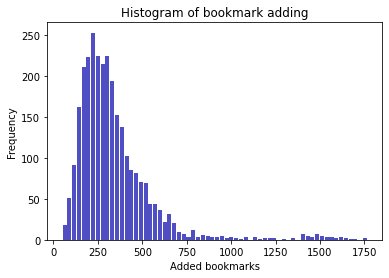

In [11]:
from matplotlib.pyplot import figure

n, bins, patches = plt.hist(x=tb.bm_added, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

plt.xlabel('Added bookmarks')
plt.ylabel('Frequency')
plt.title('Histogram of bookmark adding')
plt.rcParams["figure.figsize"] = (9, 6)
# plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.savefig('myfig')

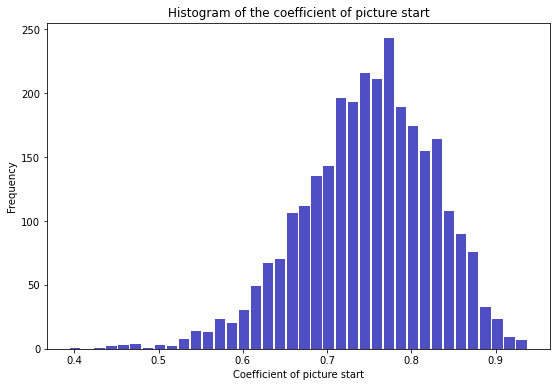

In [12]:
n, bins, patches = plt.hist(x=tb.start_coef, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

plt.xlabel('Coefficient of picture start')
plt.ylabel('Frequency')
plt.title('Histogram of the coefficient of picture start')
plt.rcParams["figure.figsize"] = (9, 6)
plt.savefig('myfig1')

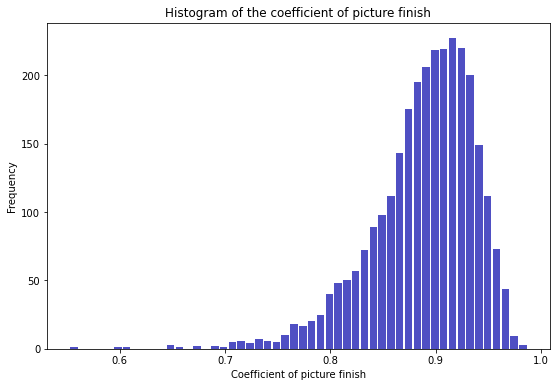

In [13]:
n, bins, patches = plt.hist(x=tb.finish_coef, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

plt.xlabel('Coefficient of picture finish')
plt.ylabel('Frequency')
plt.title('Histogram of the coefficient of picture finish')
plt.rcParams["figure.figsize"] = (9, 6)
plt.savefig('myfig2')

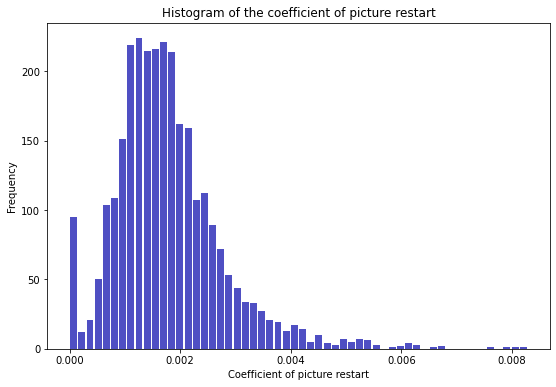

In [14]:
n, bins, patches = plt.hist(x=tb.restart_coef, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

plt.xlabel('Coefficient of picture restart')
plt.ylabel('Frequency')
plt.title('Histogram of the coefficient of picture restart')
plt.rcParams["figure.figsize"] = (9, 6)
plt.savefig('myfig3')

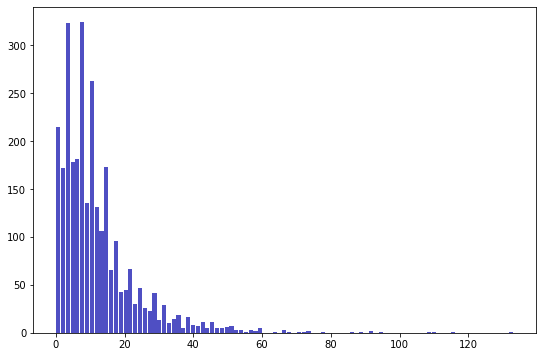

In [15]:
n, bins, patches = plt.hist(x=tb.restart_content, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

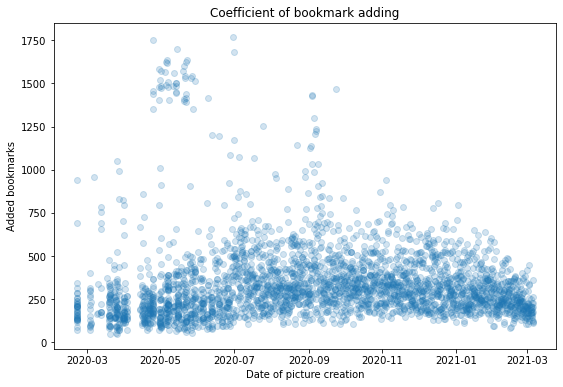

In [16]:
plt.scatter(tb.createTimestamp, tb.bm_added, alpha=0.2)

plt.xlabel('Date of picture creation')
plt.ylabel('Added bookmarks')
plt.title('Coefficient of bookmark adding')
plt.rcParams["figure.figsize"] = (9, 6)

In [315]:
tb[tb.bm_added > 1400]

picture_id  bm_added  picture_finish  picture_start  \
1490  5f634e4bfa2af900110633bd    1429.0         27185.0        38008.0   
481   5eba56baab25543150b0feb8    1525.0          4030.0         4743.0   
622   5ecd314d03ed934eec6f451d    1495.0          5954.0         6927.0   
871   5ef99910fd1a610011e1c30c    1733.0         21052.0        24283.0   
346   5ea97fc99dc16d63b6243832    1545.0          4436.0         5056.0   
320   5ea2d1759dc16d63b62437eb    1710.0          5489.0         6251.0   
562   5ec508ff684d0f7ed55129ee    1554.0          7282.0         8224.0   
571   5ec67d3a684d0f7ed5512a2a    1506.0          6013.0         6783.0   
499   5ebcf3fbab25543150b0ff05    1468.0          5020.0         5632.0   
504   5ebcfd3aab25543150b0ff0f    1664.0          5851.0         6550.0   
880   5efaf547fd1a610011e1c335    1648.0         14640.0        16364.0   
408   5eb167ab9dc16d63b624392d    1576.0          6526.0         7288.0   
384   5eac0d409dc16d63b62438a6    1533.0          6139.0         6805.0   
455   5eb4288fab25543150b0fe48    1443.0          6539.0         7216.0   
492   5ebc1495ab25543150b0fef8    1410.0          5572.0         6136.0   
636   5ece6a86b9bccc2e0f810f56    1503.0          8968.0         9870.0   
378   5eabf1a89dc16d63b624389f    1438.0          4051.0         4444.0   
553   5ec3f0d4684d0f7ed55129d3    1531.0          7283.0         7983.0   
653   5ed0acef87fcd86c097d21b1    1474.0          7466.0         8183.0   
502   5ebcf96fab25543150b0ff0d    1463.0          5711.0         6226.0   
426   5eb2cf2bab25543150b0fdfc    1584.0          5753.0         6266.0   
585   5ec7d342684d0f7ed5512a6c    1409.0          4685.0         5098.0   
597   5ec7f322684d0f7ed5512a7c    1596.0          6461.0         7030.0   
568   5ec67610684d0f7ed5512a27    1490.0          5106.0         5542.0   
402   5eb030f99dc16d63b62438fa    1529.0          5613.0         6087.0   
469   5eb9103eab25543150b0fe83    1455.0          5117.0         5544.0   
583   5ec7d0f1684d0f7ed5512a6a    1585.0          7069.0         7627.0   
485   5ebbffd0ab25543150b0feed    1417.0          3633.0         3919.0   
421   5eb2c563ab25543150b0fdf5    1589.0          7470.0         8058.0   
429   5eb3f5c6ab25543150b0fe1e    1476.0          4207.0         4535.0   
501   5ebcf7ecab25543150b0ff0c    1450.0          4496.0         4838.0   
380   5eabf4b39dc16d63b62438a1    1450.0          4748.0         5083.0   
368   5eaae7929dc16d63b6243882    1487.0          4418.0         4724.0   
333   5ea2f5139dc16d63b6243802    1419.0          6270.0         6701.0   
338   5ea2fbcb9dc16d63b6243809    1405.0          3806.0         4066.0   
349   5ea984239dc16d63b6243835    1448.0          4605.0         4905.0   
407   5eb166049dc16d63b624392c    1461.0          5103.0         5404.0   

      prelaunch_view  restart_content  start_coef  finish_coef  restart_coef  \
1490         43752.0            107.0    0.868715     0.715244      0.003936   
481           7012.0             10.0    0.676412     0.849673      0.002481   
622           9107.0             11.0    0.760624     0.859535      0.001847   
871          26948.0            131.0    0.901106     0.866944      0.006223   
346           6843.0             12.0    0.738857     0.877373      0.002705   
320           8190.0             15.0    0.763248     0.878100      0.002733   
562          10592.0             15.0    0.776435     0.885457      0.002060   
571           8786.0             15.0    0.772024     0.886481      0.002495   
499           7763.0             13.0    0.725493     0.891335      0.002590   
504           8903.0             16.0    0.735707     0.893282      0.002735   
880          19744.0             13.0    0.828809     0.894647      0.000888   
408          10160.0             12.0    0.717323     0.895445      0.001839   
384           9742.0             16.0    0.698522     0.902131      0.002606   
455           9719.0             12.0    0.742463

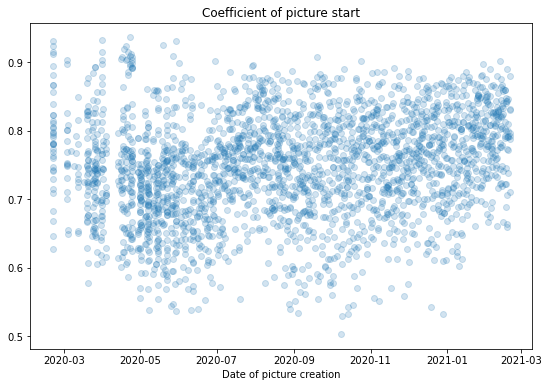

In [286]:
plt.scatter(tb.createTimestamp, tb.start_coef, alpha=0.2)

plt.xlabel('Date of picture creation')
# plt.ylabel('Coefficient of picture start')
plt.title('Coefficient of picture start')
plt.rcParams["figure.figsize"] = (9, 6)
plt.savefig('myfig4')

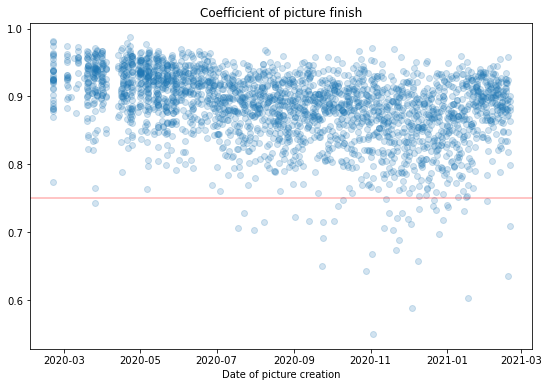

In [287]:
plt.scatter(tb.createTimestamp, tb.finish_coef, alpha=0.2)
plt.axhline(y = 0.75, color = 'r', linestyle = '-', alpha=0.3) 

plt.xlabel('Date of picture creation')
# plt.ylabel('Coefficient of picture finish')
plt.title('Coefficient of picture finish')
plt.rcParams["figure.figsize"] = (9, 6)
plt.savefig('myfig5')

In [313]:
tb = tb.sort_values(by=['finish_coef'])
tb.head()

picture_id  bm_added  picture_finish  picture_start  \
1773  5f8867bd39ec8500111ac54f     517.0          7674.0        13946.0   
1986  5fa9465301813a0018df0a92     241.0          5772.0         9799.0   
2300  5ff478c9fe800d00189fbe6b     410.0         10586.0        17567.0   
2521  602a53f9778b890011d97c1f     299.0          5838.0         9176.0   
1825  5f96d9350efbf50011618c3b     446.0         11973.0        18632.0   

      prelaunch_view  restart_content  start_coef  finish_coef  restart_coef  \
1773         16945.0             10.0    0.823016     0.550265      0.001303   
1986         13431.0              5.0    0.729581     0.589040      0.000866   
2300         20902.0              5.0    0.840446     0.602607      0.000472   
2521         11613.0             13.0    0.790149     0.636225      0.002227   
1825         23281.0             21.0    0.800309     0.642604      0.001754   

                            id createTimestamp    new  bm_added_norm  \
1773  5f8867bd39ec8500111ac54f      2020-11-03  False       0.278766   
1986  5fa9465301813a0018df0a92      2020-12-04  False       0.115065   
2300  5ff478c9fe800d00189fbe6b      2021-01-18  False       0.215302   
2521  602a53f9778b890011d97c1f      2021-02-19  False       0.149466   
1825  5f96d9350efbf50011618c3b      2020-10-28  False       0.236655   

      start_coef_norm  finish_coef_norm  restart_coef_norm      rating  \
1773         0.738953          0.000000           0.153440  518.374584   
1986         0.523228          0.088802           0.102001  242.319487   
2300         0.779197          0.119875           0.055616  411.443525   
2521         0.663070          0.196868           0.262205  300.428601   
1825         0.686528          0.211478           0.206527  447.444667   

      rating_norm  
1773     1.171160  
1986     0.829097  
2300     1.169990  
2521     1.271608  
1825     1.341188

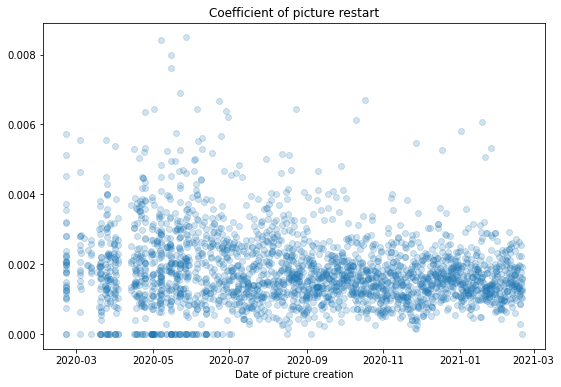

In [288]:
plt.scatter(tb.createTimestamp, tb.restart_coef, alpha=0.2)

plt.xlabel('Date of picture creation')
# plt.ylabel('Coefficient of picture restart')
plt.title('Coefficient of picture restart')
plt.rcParams["figure.figsize"] = (9, 6)
plt.savefig('myfig6')

In [46]:
scaler = preprocessing.MinMaxScaler()
# names = ["bm_added", "start_coef", "finish_coef", "restart_coef"]
# d = scaler.fit_transform(tb[["bm_added", "start_coef", "finish_coef", "restart_coef"]])
# scaled_df = pd.DataFrame(d, columns=names)

tb['bm_added_norm'] = scaler.fit_transform(tb[['bm_added']])
tb['start_coef_norm'] = scaler.fit_transform(tb[['start_coef']])
tb['finish_coef_norm'] = scaler.fit_transform(tb[['finish_coef']])
tb['restart_coef_norm'] = scaler.fit_transform(tb[['restart_coef']])

tb['rating_norm'] = 0.4*tb["start_coef"] + 0.3*tb["finish_coef"] + 0.15*tb["restart_coef_norm"] + 0.15*tb["bm_added_norm"]
# tb['rating'] = tb["start_coef"] + tb["finish_coef"] + tb["restart_coef"] + tb["bm_added"]


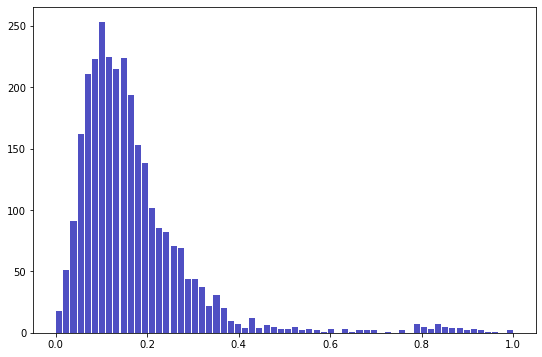

In [19]:
n, bins, patches = plt.hist(x=tb.bm_added_norm, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

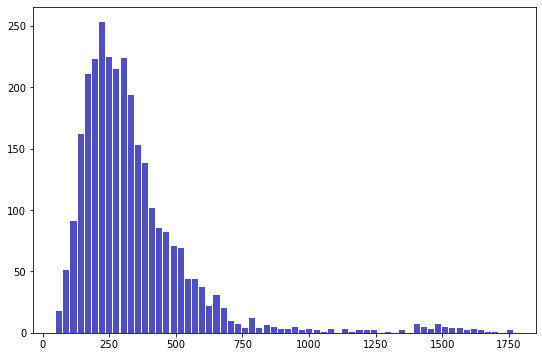

In [20]:
n, bins, patches = plt.hist(x=tb.bm_added, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

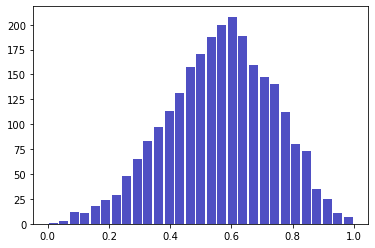

In [28]:
# n, bins, patches = plt.hist(x=tb.start_coef_norm, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

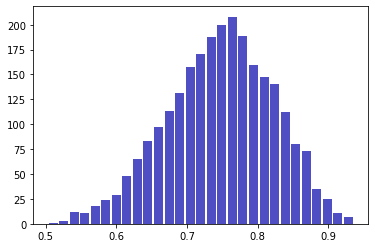

In [29]:
# n, bins, patches = plt.hist(x=tb.start_coef, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

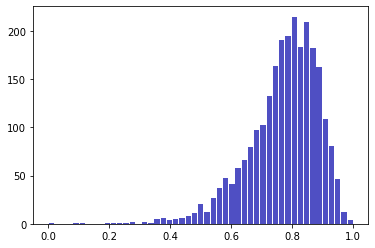

In [30]:
# n, bins, patches = plt.hist(x=tb.finish_coef_norm, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

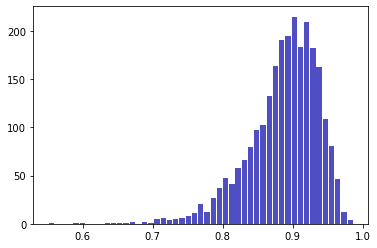

In [31]:
# n, bins, patches = plt.hist(x=tb.finish_coef, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

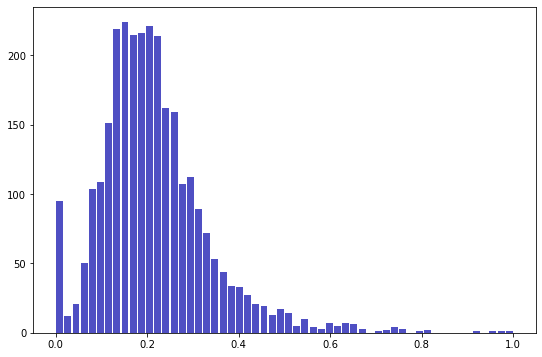

In [21]:
n, bins, patches = plt.hist(x=tb.restart_coef_norm, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

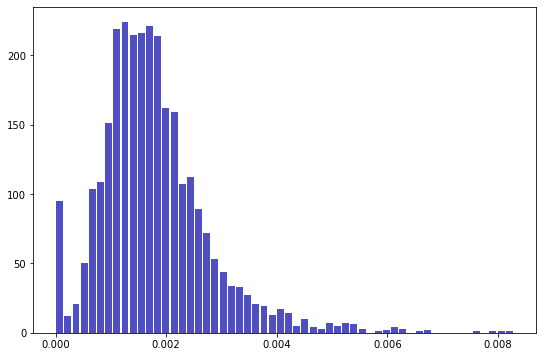

In [22]:
n, bins, patches = plt.hist(x=tb.restart_coef, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

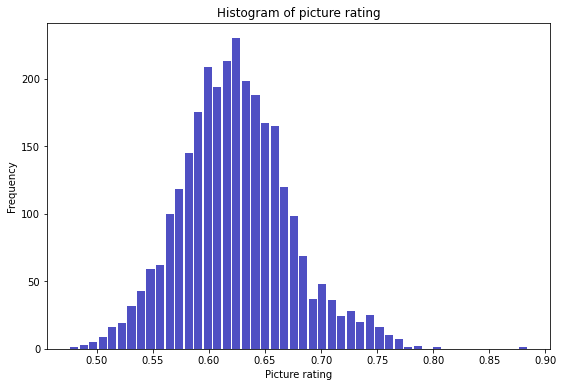

In [47]:
n, bins, patches = plt.hist(x=tb.rating_norm, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
# plt.axvline(x = 2, color = 'r', linestyle = '-') 

plt.xlabel('Picture rating')
plt.ylabel('Frequency')
plt.title('Histogram of picture rating')
plt.savefig('myfig7')

In [48]:
tb.describe()

bm_added  picture_finish  picture_start  prelaunch_view  \
count  2894.000000     2894.000000    2894.000000     2894.000000   
mean    339.386662     6265.859710    7146.551140     9287.270905   
std     224.723978     3929.901959    4597.425203     5469.566647   
min      49.000000      463.000000     496.000000      757.000000   
25%     206.000000     3375.500000    3737.750000     5413.500000   
50%     290.000000     5796.500000    6534.000000     8802.500000   
75%     399.000000     8421.250000    9637.250000    12315.750000   
max    1766.000000    28089.000000   38508.000000    44343.000000   

       restart_content   start_coef  finish_coef  restart_coef  bm_added_norm  \
count      2894.000000  2894.000000  2894.000000   2894.000000    2894.000000   
mean         12.004838     0.748937     0.888154      0.001785       0.169124   
std          11.851366     0.077742     0.049636      0.000995       0.130882   
min           0.000000     0.394076     0.552424      0.000000       0.000000   
25%           5.000000     0.700901     0.863570      0.001155       0.091439   
50%           9.000000     0.755010     0.896147      0.001642       0.140361   
75%          15.000000     0.804443     0.923525      0.002215       0.203844   
max         133.000000     0.937780     0.987152      0.008278       1.000000   

       restart_coef_norm  rating_norm  start_coef_norm  finish_coef_norm  
count        2894.000000  2894.000000      2894.000000       2894.000000  
mean            0.215677     0.623741         0.652674          0.772275  
std             0.120228     0.048741         0.142986          0.114177  
min             0.000000     0.475641         0.000000          0.000000  
25%             0.139501     0.591950         0.564324          0.715725  
50%             0.198365     0.621789         0.663842          0.790662  
75%             0.267620     0.653654         0.754761          0.853639  
max             1.000000     0.883897         1.000000          1.000000

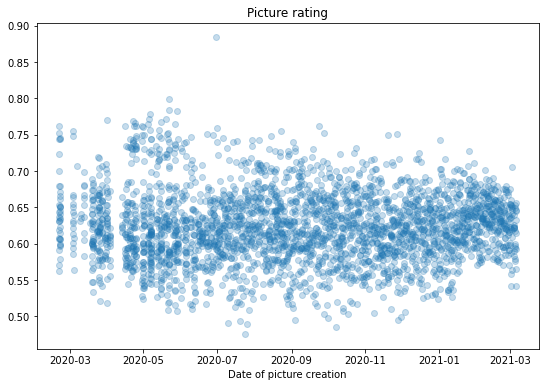

In [49]:
plt.scatter(tb.createTimestamp, tb.rating_norm, alpha=0.25)

plt.xlabel('Date of picture creation')
# plt.ylabel('Coefficient of picture finish')
plt.title('Picture rating')
plt.savefig('myfig8')

In [50]:
tb.rating_norm.describe()

count    2894.000000
mean        0.623741
std         0.048741
min         0.475641
25%         0.591950
50%         0.621789
75%         0.653654
max         0.883897
Name: rating_norm, dtype: float64

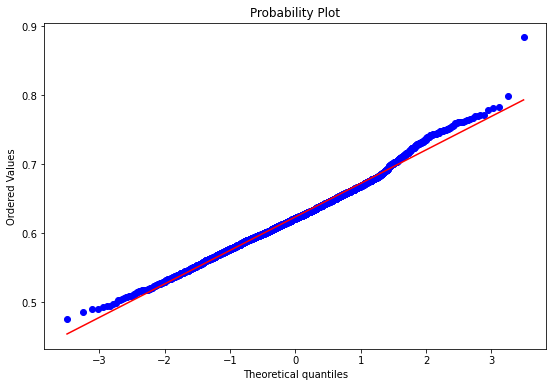

In [51]:
import pylab 
import scipy.stats as stats
 
stats.probplot(tb.rating_norm, dist="norm", plot=pylab)
pylab.show()

In [55]:
tb = tb.sort_values(by=['rating_norm'], ascending=False)
tb.head(20)

picture_id  bm_added  picture_finish  picture_start  \
890   5ef99910fd1a610011e1c30c    1766.0         21261.0        24512.0   
597   5ec7f322684d0f7ed5512a7c    1635.0          6690.0         7268.0   
583   5ec7d0f1684d0f7ed5512a6a    1622.0          7302.0         7874.0   
653   5ed0acef87fcd86c097d21b1    1513.0          7664.0         8379.0   
421   5eb2c563ab25543150b0fdf5    1637.0          7699.0         8296.0   
546   5ec3e19c684d0f7ed55129ca     223.0          8803.0         9381.0   
407   5eb166049dc16d63b624392c    1491.0          5241.0         5559.0   
192   5e833fdc1f1ec26f545a9576     178.0          7141.0         7395.0   
300   5ea061109dc16d63b624378f     268.0         10757.0        10897.0   
512   5ebe7a7bab25543150b0ff57     272.0          5919.0         6886.0   
320   5ea2d1759dc16d63b62437eb    1753.0          5693.0         6466.0   
402   5eb030f99dc16d63b62438fa    1565.0          5801.0         6288.0   
636   5ece6a86b9bccc2e0f810f56    1541.0          9212.0        10136.0   
1615  5f634e4bfa2af900110633bd    1467.0         27579.0        38508.0   
345   5ea30aac9dc16d63b6243812     225.0          6945.0         7447.0   
347   5ea981c89dc16d63b6243833    1402.0          4855.0         5088.0   
310   5ea1ad4b9dc16d63b62437c3     230.0          7256.0         7629.0   
234   5e971a43441ed54d0274d1ae     213.0          6584.0         6788.0   
14    5e4fbfd304aea3784208a458     212.0          8237.0         8622.0   
368   5eaae7929dc16d63b6243882    1519.0          4587.0         4899.0   

      prelaunch_view  restart_content  start_coef  finish_coef  restart_coef  \
890          27210.0            133.0    0.900845     0.867371      0.006256   
597           9583.0             30.0    0.758426     0.920473      0.004484   
583          10052.0             22.0    0.783327     0.927356      0.003013   
653          10377.0             24.0    0.807459     0.914668      0.003132   
421          10400.0             18.0    0.797692     0.928038      0.002338   
546          10138.0             51.0    0.925330     0.938386      0.005793   
407           7328.0             17.0    0.758597     0.942795      0.003244   
192           7928.0             38.0    0.932770     0.965652      0.005321   
300          11620.0             47.0    0.937780     0.987152      0.004369   
512           8092.0             49.0    0.850964     0.859570      0.008278   
320           8468.0             15.0    0.763581     0.880452      0.002635   
402           8146.0             15.0    0.771913     0.922551      0.002586   
636          12500.0             19.0    0.810880     0.908840      0.002063   
1615         44343.0            116.0    0.868412     0.716189      0.004206   
345           8338.0             42.0    0.893140     0.932590      0.006048   
347           6431.0             11.0    0.791168     0.954206      0.002266   
310           8351.0             38.0    0.913543     0.951108      0.005237   
234           7490.0             34.0    0.906275     0.969947      0.005164   
14            9425.0             43.0    0.914801     0.955347      0.005220   
368           6913.0             17.0    0.708665     0.936314      0.003706   

                            id         createTimestamp    new  bm_added_norm  \
890   5ef99910fd1a610011e1c30c 2020-06-30 00:00:00.000  False       1.000000   
597   5ec7f322684d0f7ed5512a7c 2020-05-22 15:43:26.613  False       0.923704   
583   5ec7d0f1684d0f7ed5512a6a 2020-05-22 13:17:33.947  False       0.916133   
653   5ed0acef87fcd86c097d21b1 2020-05-29 06:34:17.980  False       0.852650   
421   5eb2c563ab25543150b0fdf5 2020-05-06 14:10:40.090  False       0.924869   
546   5ec3e19c684d0f7ed55129ca 2020-05-19 13:39:38.709  False       0.101340   
407   5eb166049dc16d63b624392c 2020-05-05 13:11:30.033  False       0.839837   
192   5e833fdc1f1ec26f545a9576 2020-03-31 13:04:28.551  False       0.075131   
300   5ea061109dc16d63b624378f 2020-04-22 1

In [44]:
len(tb)/20

144.7

In [56]:
all_feed_tags = all_feed[all_feed.new == False][['id', 'tags', 'createTimestamp']].explode('tags')
all_feed_tags

id         tags createTimestamp
21    6041f51bb06e1200115c09b6       travel      2021-03-06
21    6041f51bb06e1200115c09b6    buildings      2021-03-06
22    6041d21cb06e1200115c09b5         food      2021-03-06
23    6041d03fb06e1200115c09b4      animals      2021-03-06
24    6041cab8b06e1200115c09b2  butterflies      2021-03-06
...                        ...          ...             ...
2914  5ef2088f73613e00112db444          NaN      2020-06-26
2915  5ef2066c73613e00112db443          NaN      2020-06-25
2916  5ef1e6e973613e00112db43b          NaN      2020-06-24
2917  5ef1ffb873613e00112db441          NaN      2020-06-23
2918  5ef1f9fd73613e00112db440          NaN      2020-06-22

[4076 rows x 3 columns]

In [57]:
all_feed_tags = all_feed_tags.merge(tb[['rating_norm', 'picture_id', "start_coef", "finish_coef", "restart_coef", 
                       "bm_added"]], left_on='id', right_on='picture_id', how='left')


In [58]:
all_feed_tags.groupby('tags')['rating_norm', "start_coef", "finish_coef", "restart_coef", 
                              "bm_added"].median().reset_index()

<ipython-input-58-0bb4e4e975be>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_feed_tags.groupby('tags')['rating_norm', "start_coef", "finish_coef", "restart_coef",


tags  rating_norm  start_coef  finish_coef  restart_coef  \
0           animals     0.602500    0.711643     0.898032      0.001420   
1               art     0.591390    0.720519     0.848047      0.001432   
2             birds     0.615330    0.752277     0.901275      0.001538   
3             blend     0.572915    0.724657     0.809848      0.001254   
4         buildings     0.657368    0.783571     0.895181      0.001956   
5       butterflies     0.609863    0.746267     0.883568      0.001465   
6   editors' choice     0.659123    0.754995     0.891081      0.002751   
7           fantasy     0.590106    0.693415     0.881620      0.001447   
8           fashion     0.604711    0.762328     0.878120      0.001064   
9           flowers     0.628581    0.756595     0.888585      0.002079   
10             food     0.624060    0.766969     0.888788      0.001870   
11         holidays     0.638375    0.798185     0.852734      0.001714   
12       horoscopes     0.644297    0.773546     0.888076      0.001780   
13         interior     0.661542    0.829009     0.888786      0.001897   
14         mandalas     0.705911    0.858108     0.911056      0.003526   
15           nature     0.630714    0.719582     0.912142      0.001858   
16            other     0.599297    0.732571     0.882568      0.001329   
17           people     0.608359    0.742286     0.888122      0.001414   
18              sea     0.609556    0.706135     0.898908      0.001738   
19           simple     0.666400    0.834967     0.927454      0.002234   
20           travel     0.643843    0.729511     0.912747      0.001915   
21         vehicles     0.629903    0.772093     0.889971      0.001648   

    bm_added  
0      295.0  
1      214.5  
2      230.0  
3      224.5  
4      509.0  
5      221.0  
6      423.0  
7      298.0  
8      242.0  
9      252.0  
10     227.0  
11     430.0  
12     437.0  
13     376.5  
14     282.5  
15     413.0  
16     290.0  
17     257.0  
18     324.0  
19     224.0  
20     507.0  
21     338.5

In [80]:
all_feed_tags[all_feed_tags.bm_added > 1250].groupby('tags').nunique()

id  createTimestamp  rating_norm  picture_id  start_coef  \
tags                                                                  
animals     8                8            8           8           8   
birds       1                1            1           1           1   
buildings   9                9            9           9           9   
nature     20               20           20          20          20   
people      5                5            5           5           5   
sea         5                5            5           5           5   
travel     49               48           49          49          49   
vehicles   11               11           11          11          11   

           finish_coef  restart_coef  bm_added  
tags                                            
animals              8             8         8  
birds                1             1         1  
buildings            9             9         9  
nature              20            20        19  
people               5             5         5  
sea                  5             5         5  
travel              49            49        45  
vehicles            11            11        11

In [84]:
all_feed_tags[all_feed_tags.bm_added > 1250]

id      tags         createTimestamp  rating_norm  \
1470  5f634e4bfa2af900110633bd    travel 2020-09-24 00:00:00.000     2.505460   
1669  5f3bc45b5e6e4800188c76c4    travel 2020-09-05 00:00:00.000     2.303517   
1670  5f3bc45b5e6e4800188c76c4    nature 2020-09-05 00:00:00.000     2.303517   
1671  5f3bc45b5e6e4800188c76c4       sea 2020-09-05 00:00:00.000     2.303517   
1680  5f3ab917e0a5ec0018d42fe2    travel 2020-09-04 00:00:00.000     2.377273   
...                        ...       ...                     ...          ...   
3196  5ea2f5139dc16d63b6243802    travel 2020-04-24 14:17:52.692     2.531897   
3197  5ea2f5139dc16d63b6243802  vehicles 2020-04-24 14:17:52.692     2.531897   
3212  5ea2d1759dc16d63b62437eb    travel 2020-04-24 11:45:53.080     2.659915   
3213  5ea2d1759dc16d63b62437eb    nature 2020-04-24 11:45:53.080     2.659915   
3214  5ea2d1759dc16d63b62437eb    people 2020-04-24 11:45:53.080     2.659915   

                    picture_id  start_coef  finish_coef  restart_coef  \
1470  5f634e4bfa2af900110633bd    0.868715     0.715244      0.003936   
1669  5f3bc45b5e6e4800188c76c4    0.755437     0.907872      0.001567   
1670  5f3bc45b5e6e4800188c76c4    0.755437     0.907872      0.001567   
1671  5f3bc45b5e6e4800188c76c4    0.755437     0.907872      0.001567   
1680  5f3ab917e0a5ec0018d42fe2    0.769318     0.875185      0.001897   
...                        ...         ...          ...           ...   
3196  5ea2f5139dc16d63b6243802    0.783468     0.935681      0.001595   
3197  5ea2f5139dc16d63b6243802    0.783468     0.935681      0.001595   
3212  5ea2d1759dc16d63b62437eb    0.763248     0.878100      0.002733   
3213  5ea2d1759dc16d63b62437eb    0.763248     0.878100      0.002733   
3214  5ea2d1759dc16d63b62437eb    0.763248     0.878100      0.002733   

      bm_added  
1470    1429.0  
1669    1256.0  
1670    1256.0  
1671    1256.0  
1680    1387.0  
...        ...  
3196    1419.0  
3197    1419.0  
3212    1710.0  
3213    1710.0  
3214    1710.0  

[108 rows x 9 columns]

In [111]:
json_data_image = db['Image'].find({})

img_arr = all_feed.id.tolist()
images = pd.DataFrame()

tesselatorCoreInfo_arr = []
for document in json_data_image:
    id = document['_id'].__str__()        
    if id in img_arr:            
        if 'totalshapesCount' in document['tesselatorCoreInfo']:
            tesselatorCoreInfo = document['tesselatorCoreInfo']
            totalshapesCount = tesselatorCoreInfo['totalshapesCount']
            colorsCount = tesselatorCoreInfo['colorsCount']
            tesselatorCoreInfo_arr.append({'id': id, 'totalshapesCount': totalshapesCount, 
                                           'colorsCount': colorsCount})   

In [192]:
images = pd.json_normalize(tesselatorCoreInfo_arr, max_level=0) 
all_feed_tags = all_feed_tags.merge(images, how='left', on='id')

id  totalshapesCount  colorsCount
0     5e4fd0e204aea3784208a460               553           66
1     5e6a2c627bd03150fd3f1484               533           78
2     5e4fb75104aea3784208a450               158           34
3     5e5e2bdad7287a3b27a136c1               428           42
4     5e5e3698e5f0e43cc728b004               347           99
...                        ...               ...          ...
2554  6033bbc4778b890011d97c93               742           46
2555  6033bfc6778b890011d97c94               362           51
2556  6033c2cc778b890011d97c95               455           55
2557  6033c4a2778b890011d97c96               462           63
2558  6033c5ee778b890011d97c97              1043           81

[2559 rows x 3 columns]

In [216]:
find_corr = all_feed_tags[['id', 'totalshapesCount', 'tags', 'colorsCount', "start_coef", 'finish_coef', 'restart_coef', 
               'bm_added']].drop_duplicates()

correlation = find_corr.groupby('tags').corr().reset_index()

In [218]:
correlation.to_csv('corr.csv')

In [212]:
# without mandals
find_corr_ = all_feed_tags[~all_feed_tags.id.isin(
    all_feed_tags[all_feed_tags.tags=='mandalas'].id.tolist())][['id', 'totalshapesCount', 'colorsCount', "start_coef",
                                                                 'finish_coef', 'restart_coef', 'bm_added']].drop_duplicates()
find_corr_.corr()


totalshapesCount  colorsCount  start_coef  finish_coef  \
totalshapesCount          1.000000     0.294945   -0.039292    -0.457203   
colorsCount               0.294945     1.000000   -0.003452    -0.226953   
start_coef               -0.039292    -0.003452    1.000000    -0.152795   
finish_coef              -0.457203    -0.226953   -0.152795     1.000000   
restart_coef              0.045275    -0.027670    0.150948     0.024848   
bm_added                  0.181303     0.063286    0.245293    -0.105146   

                  restart_coef  bm_added  
totalshapesCount      0.045275  0.181303  
colorsCount          -0.027670  0.063286  
start_coef            0.150948  0.245293  
finish_coef           0.024848 -0.105146  
restart_coef          1.000000  0.217678  
bm_added              0.217678  1.000000

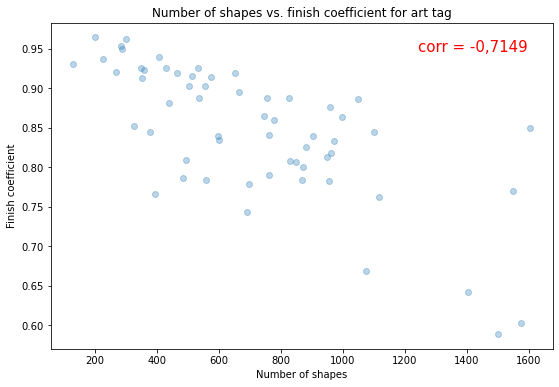

In [367]:
plt.scatter(find_corr[find_corr.tags=='art'].totalshapesCount, 
            find_corr[find_corr.tags=='art'].finish_coef, alpha=0.3)

left, width = .45, .5
bottom, height = .45, .5
right = left + width
top = bottom + height
ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height, fill=False)
# p.set_transform(ax.transAxes)
# p.set_clip_on(False)
# ax.add_patch(p)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for art tag')
ax.text(right, top, 'corr = -0,7149', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig9')

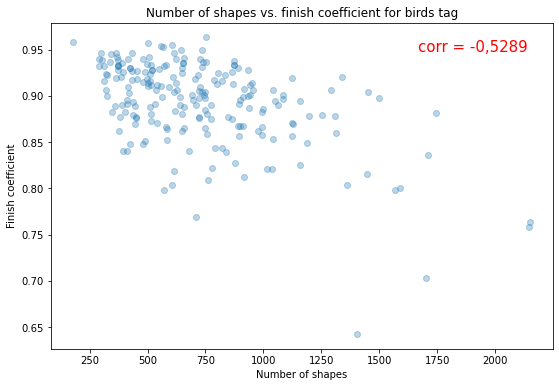

In [369]:
plt.scatter(find_corr[find_corr.tags=='birds'].totalshapesCount, 
            find_corr[find_corr.tags=='birds'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for birds tag')

left, width = .45, .5
bottom, height = .45, .5
right = left + width
top = bottom + height
ax = plt.gca()

ax.text(right, top, 'corr = -0,5289', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig10')

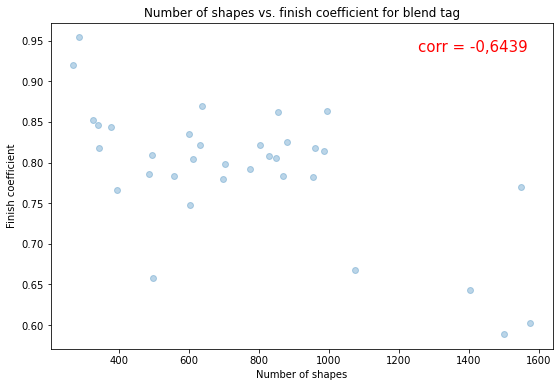

In [370]:
plt.scatter(find_corr[find_corr.tags=='blend'].totalshapesCount, 
            find_corr[find_corr.tags=='blend'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for blend tag')
ax = plt.gca()

ax.text(right, top, 'corr = -0,6439', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig11')

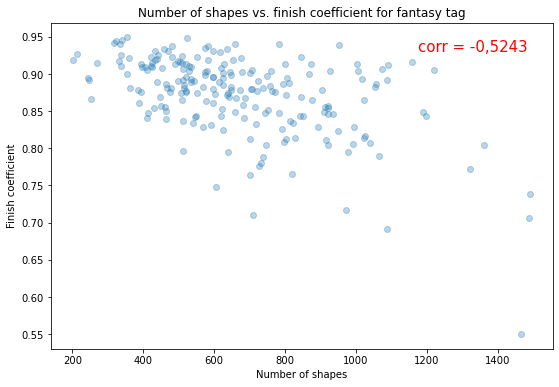

In [371]:
plt.scatter(find_corr[find_corr.tags=='fantasy'].totalshapesCount, 
            find_corr[find_corr.tags=='fantasy'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for fantasy tag')

ax = plt.gca()

ax.text(right, top, 'corr = -0,5243', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig12')

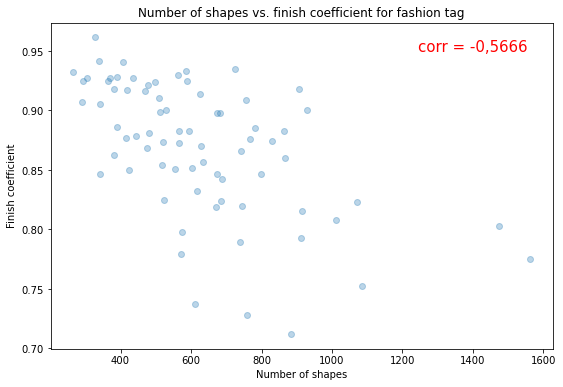

In [372]:
plt.scatter(find_corr[find_corr.tags=='fashion'].totalshapesCount, 
            find_corr[find_corr.tags=='fashion'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for fashion tag')

ax = plt.gca()

ax.text(right, top, 'corr = -0,5666', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig13')

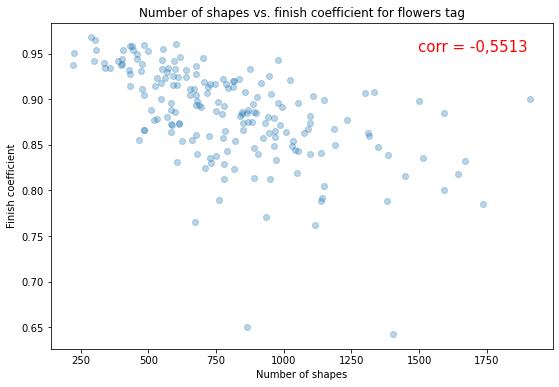

In [373]:
plt.scatter(find_corr[find_corr.tags=='flowers'].totalshapesCount, 
            find_corr[find_corr.tags=='flowers'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for flowers tag')

ax = plt.gca()

ax.text(right, top, 'corr = -0,5513', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig14')

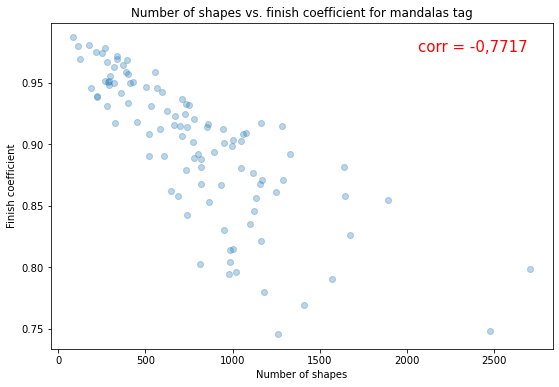

In [374]:
plt.scatter(find_corr[find_corr.tags=='mandalas'].totalshapesCount, 
            find_corr[find_corr.tags=='mandalas'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for mandalas tag')

ax = plt.gca()

ax.text(right, top, 'corr = -0,7717', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig15')

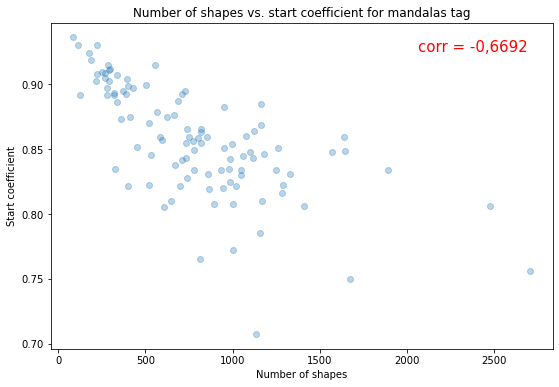

In [375]:
plt.scatter(find_corr[find_corr.tags=='mandalas'].totalshapesCount, 
            find_corr[find_corr.tags=='mandalas'].start_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Start coefficient')
plt.title('Number of shapes vs. start coefficient for mandalas tag')

ax = plt.gca()

ax.text(right, top, 'corr = -0,6692', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)


plt.savefig('myfig16')

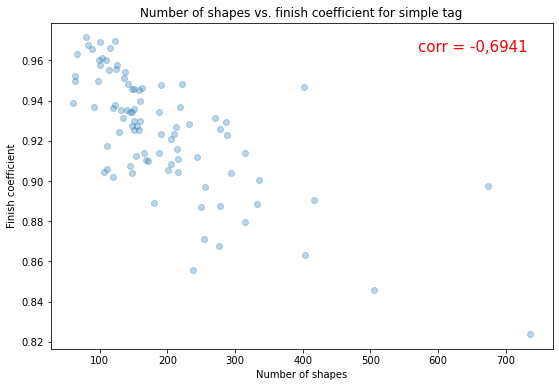

In [376]:
plt.scatter(find_corr[find_corr.tags=='simple'].totalshapesCount, 
            find_corr[find_corr.tags=='simple'].finish_coef, alpha=0.3)

plt.xlabel('Number of shapes')
plt.ylabel('Finish coefficient')
plt.title('Number of shapes vs. finish coefficient for simple tag')

ax = plt.gca()

ax.text(right, top, 'corr = -0,6941', color = 'r',
        size = 15,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

plt.savefig('myfig17')

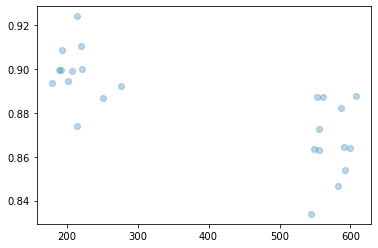

In [231]:
plt.scatter(find_corr[find_corr.tags=='horoscopes'].bm_added, find_corr[find_corr.tags=='horoscopes'].finish_coef, alpha=0.3)

In [ ]:
# sql = '''
# SELECT distinct event_date, event_timestamp, user_id, param.key, param.value.string_value
# FROM `lwapps-coloring.analytics_218793363.events_*` e,
#     UNNEST(event_params) param
# where _TABLE_SUFFIX BETWEEN '20200613' AND '20210219'
# and event_name in ("core_picture_finish", 'picture_finish')
# and param.key in ("picture_id", 'undo_used', 'hint_used', 'floating_hint_tap', 'floating_undo_tap')
# '''
# hints_dt = client.query(sql, project=project_id).to_dataframe()

# hints = hints_dt.copy()
# ht = hints.pivot_table(index=['event_date','event_timestamp','user_id'], columns='key', 
#                   values='string_value', aggfunc='first').reset_index()
# ht = ht[ht.picture_id.isin(all_feed.id.tolist())] 

# ht['floating_hint_tap'] = ht['floating_hint_tap'].replace(np.nan, '0')
# ht['floating_undo_tap'] = ht['floating_undo_tap'].replace(np.nan, '0')
# ht['hint_used'] = ht['hint_used'].replace(np.nan, '0')
# ht['undo_used'] = ht['undo_used'].replace(np.nan, '0')
# ht['floating_hint_tap'] = ht['floating_hint_tap'].astype(int)
# ht['floating_undo_tap'] = ht['floating_undo_tap'].astype(int)
# ht['hint_used'] = ht['hint_used'].astype(int)
# ht['undo_used'] = ht['undo_used'].astype(int)

# undo_used = ht[(ht.undo_used != 0) | 
#                (ht.floating_undo_tap != 0)].groupby('picture_id').user_id.nunique().reset_index(name = 'undo_used')
# hint_used = ht[(ht.hint_used != 0) |
#                (ht.floating_hint_tap != 0)].groupby('picture_id').user_id.nunique().reset_index(name = 'hint_used')

# hints = undo_used.merge(hint_used, on='picture_id', how='outer')
# tb = tb.merge(hints, on='picture_id', how='left')
# tb[["undo_used", "hint_used"]] = tb[["undo_used", "hint_used"]].fillna(value=0)
# tb.replace([np.inf, -np.inf], 0, inplace = True)

# tb['undo_coef'] = tb['undo_used']/tb['picture_start']
# tb['hint_coef'] = tb['hint_used']/tb['picture_start']

In [ ]:
tb.start_coef.max()

In [ ]:
tb[tb.finish_coef>1]

In [ ]:
all_feed[all_feed.createTimestamp >= pd.to_datetime(dt.date(2020,6,29))]
# new_pectures_time

In [ ]:
1712/len(all_feed)

In [ ]:
len(all_feed)-1781